# Daily Seasonally Bootstrapped Future Projection
- Single Location AR(1), accounting for autocorrelation
- Can also be implemented spatially, would require some rewriting, ideally keeping everything in netcdf instead of jumping from nc to df

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
# requires cartopy to be installed
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.ticker as mticker

import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
#from matplotlib.colors import TwoSlopeNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm
import rioxarray
from shapely.geometry import mapping
import geopandas as gpd
import dask

# Data Preprocessing for NetCdf Files

In [4]:
# we want all days at an individual location, this is just loading the data
# This code should work with pandas df, and the preliminary steps can be avoided
base_path = '/data/rsriver/c/guerrer4/share/wfpi_no_interp/'
xarray_array = []

for year in np.arange(2001,2023):
    filename = base_path + str(year) + '_WFPI_no_interpolation_day1.nc'
    dataset = xr.open_dataset(filename)

    dataset = dataset.drop_vars('spatial_ref')
    dataset = dataset.drop_vars('band')
    
    dataset['year'] = year
    xarray_array.append(dataset)

xarray_array = xr.concat(xarray_array, dim='year')

In [5]:
shapefile = gpd.read_file('shape/us_eco_l3.shp')

In [6]:
col_names = ['6', '7', '5', '14', '13', '81', '85', '1', '78', '4', '9', '80']
grouped = shapefile.groupby('US_L3CODE')

In [7]:
group_n = []
for g_group in col_names:
    group_n.append(grouped.get_group(g_group))

In [8]:
variable = xarray_array['fwpi']
variable = variable.rio.write_crs("EPSG:4326")

In [9]:
def functionationer(shapefile_indv):
    masked = variable.rio.clip(shapefile_indv.geometry.apply(mapping), shapefile_indv.crs, drop=True)    
    global mean_value
    mean_value = masked.mean(dim=['x', 'y']).copy(deep=True)  # Replace 'dim1' and 'dim2' with your actual dimensions
    time_series_vals.append(mean_value)

/tmp/ipykernel_107504/2481763904.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_values_smooth['day'] = np.arange(1, 366)


wfpi     57.678057
day    -108.714007
dtype: float64
None
zeroed nan pacf at 1 lag is 0.8550931942238456
dropped nan pacf at 1 lag is 0.8550931942238456


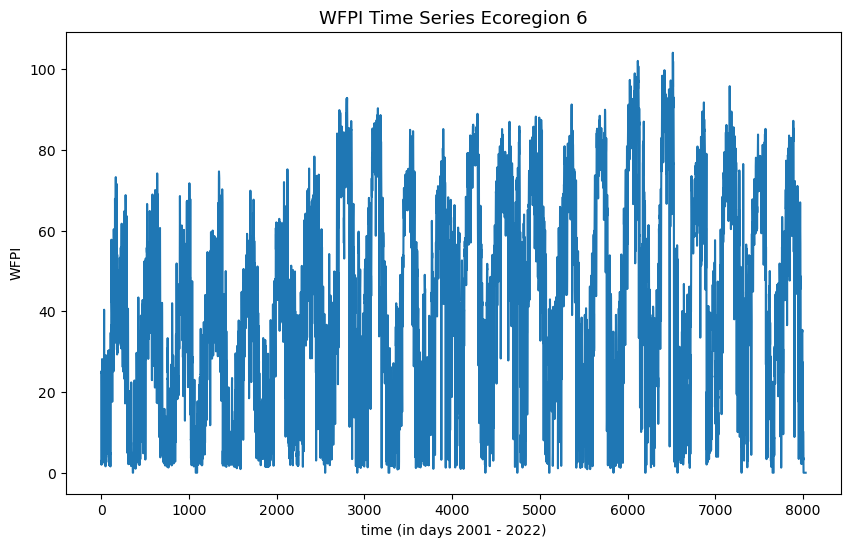

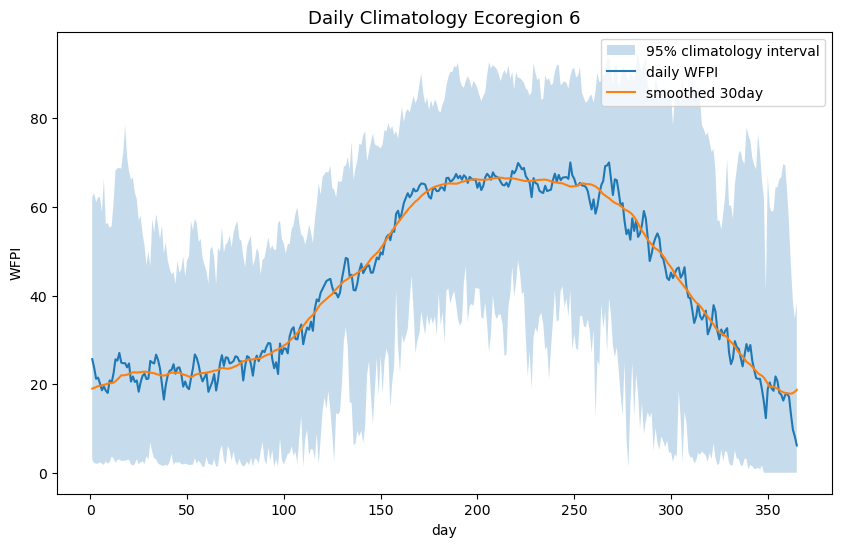

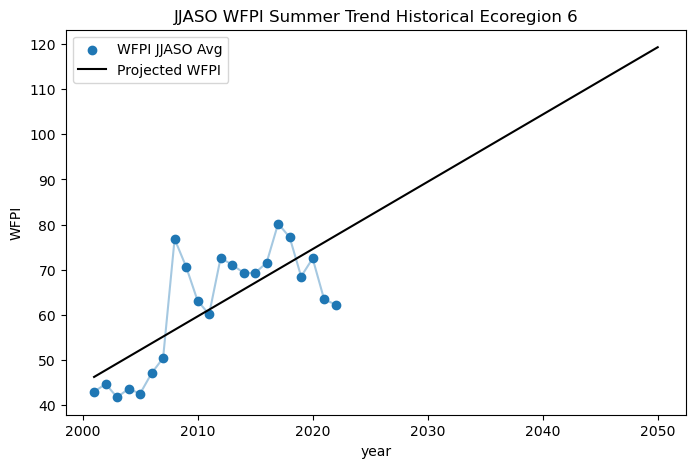

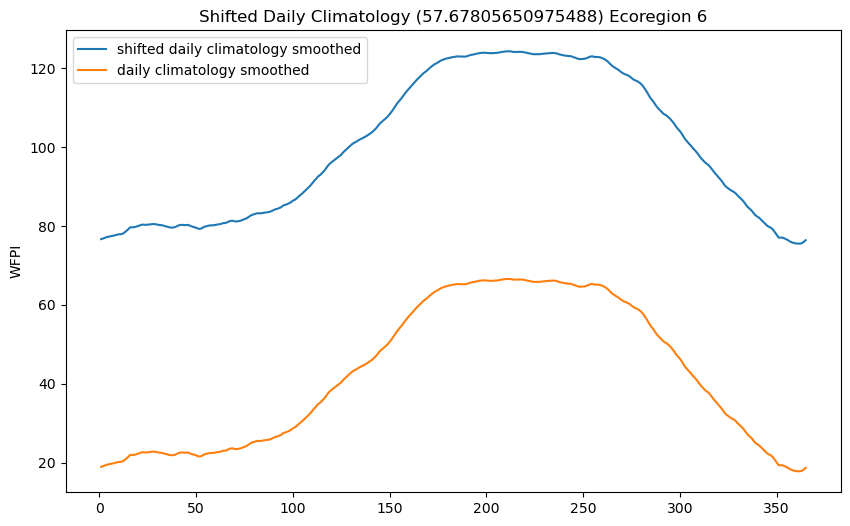

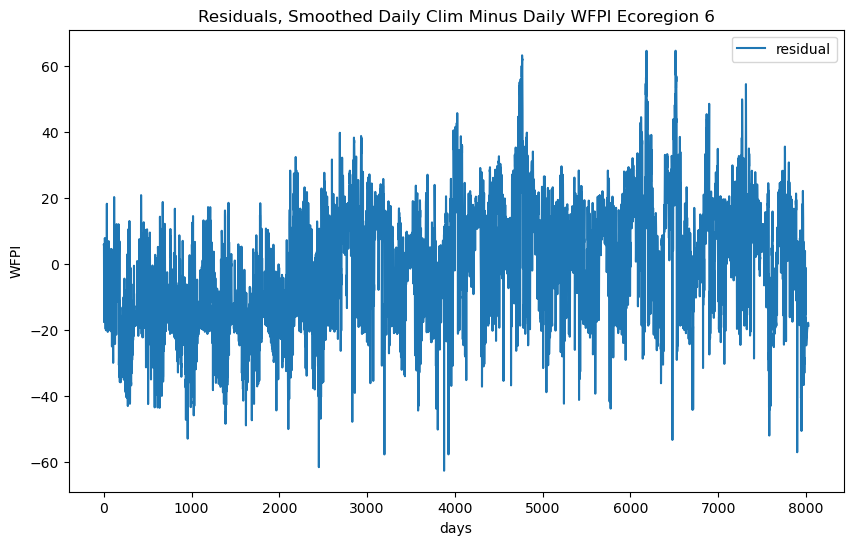

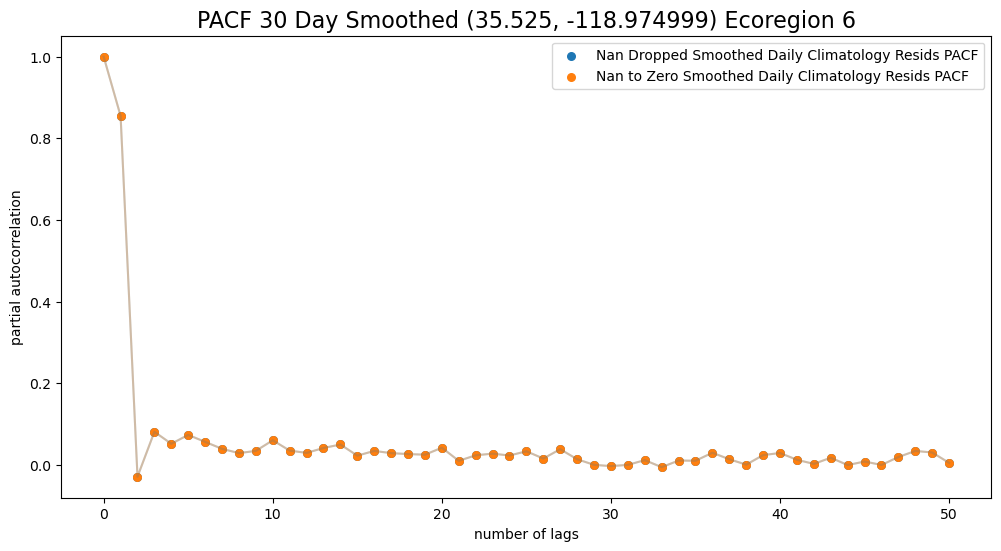

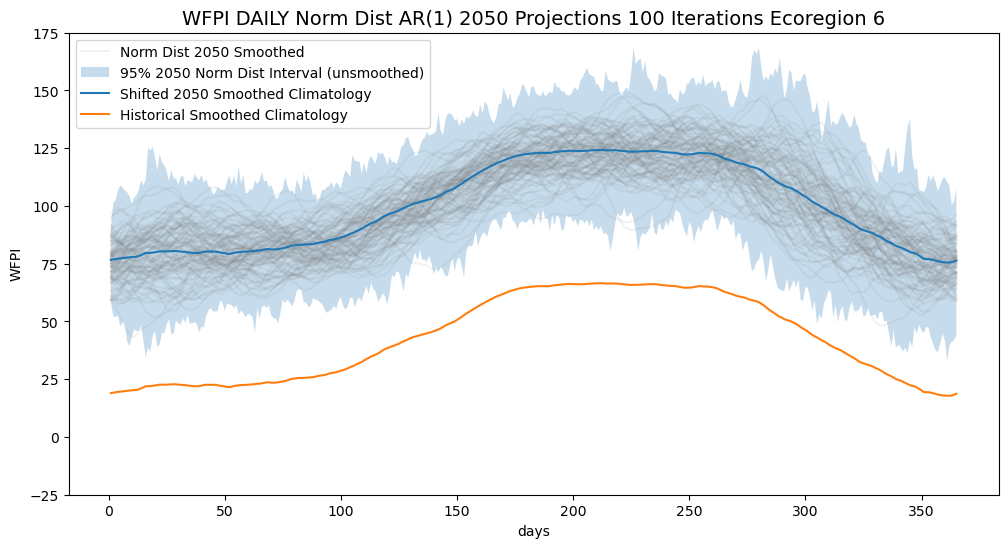

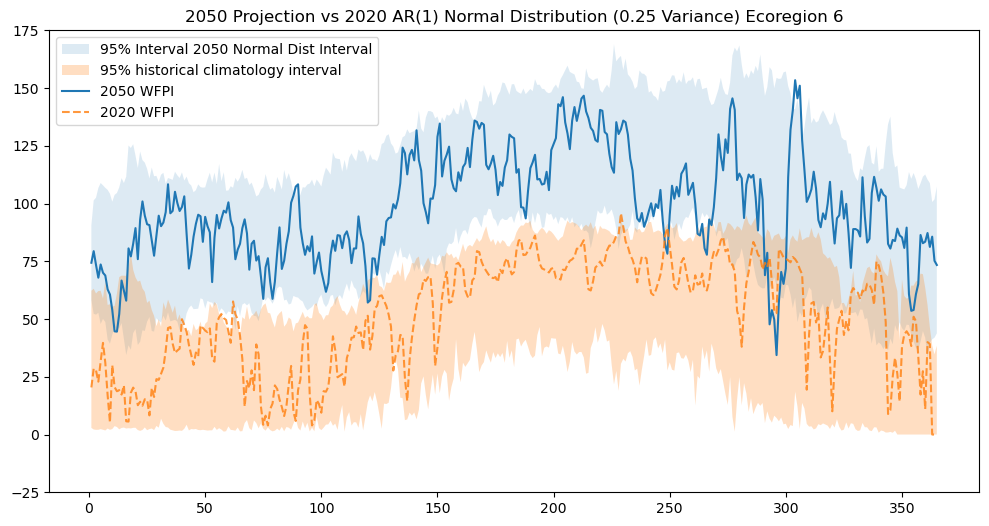

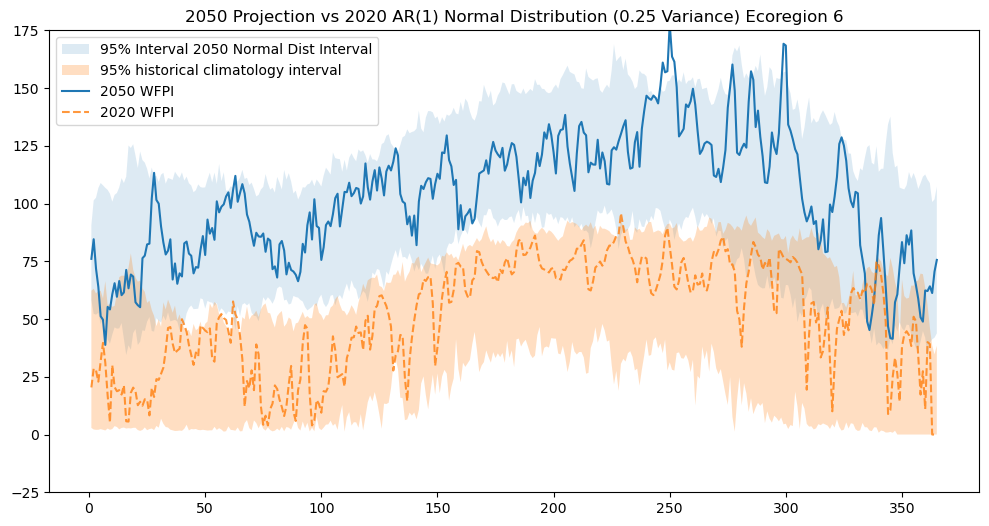

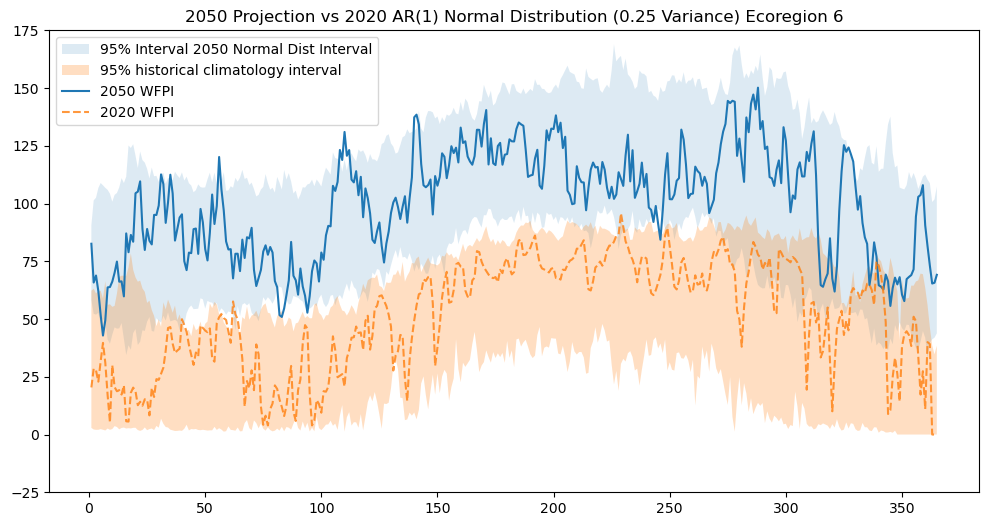

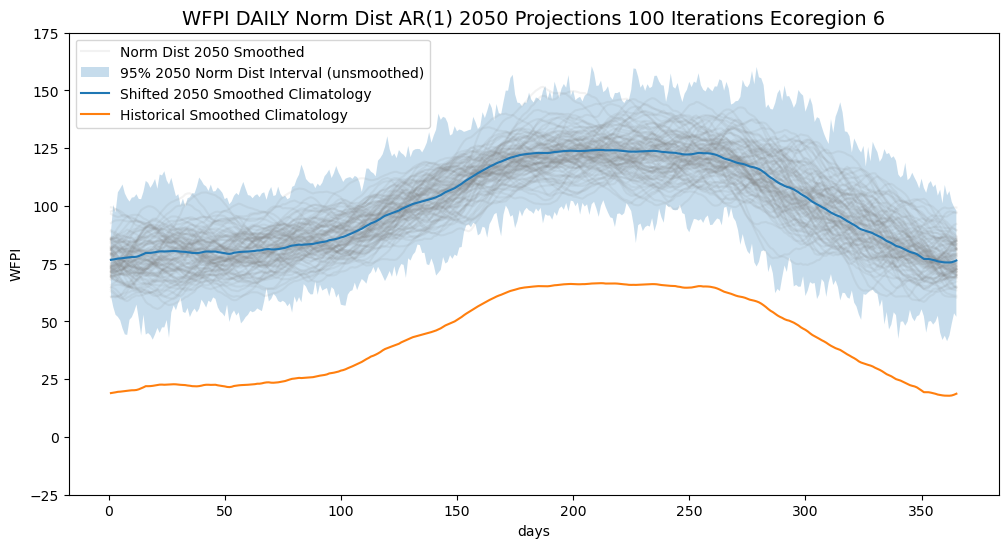

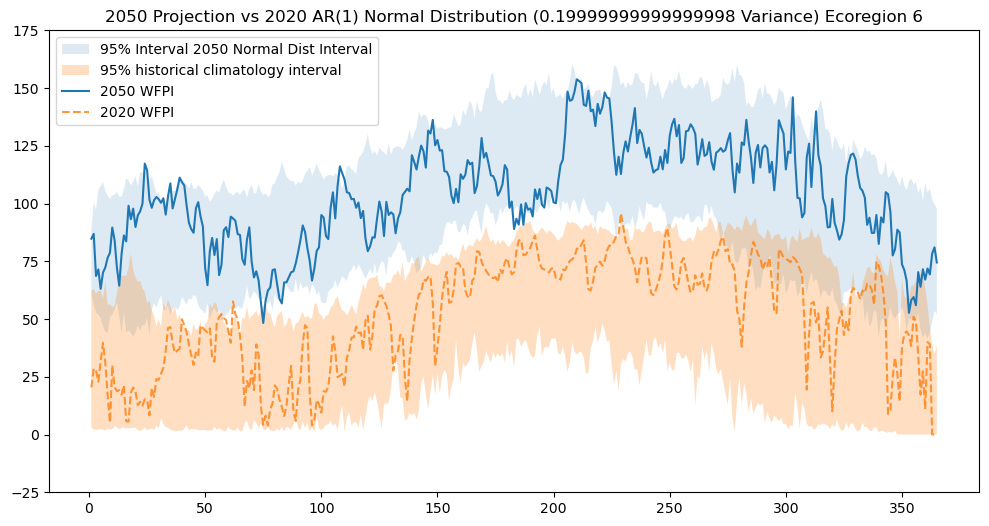

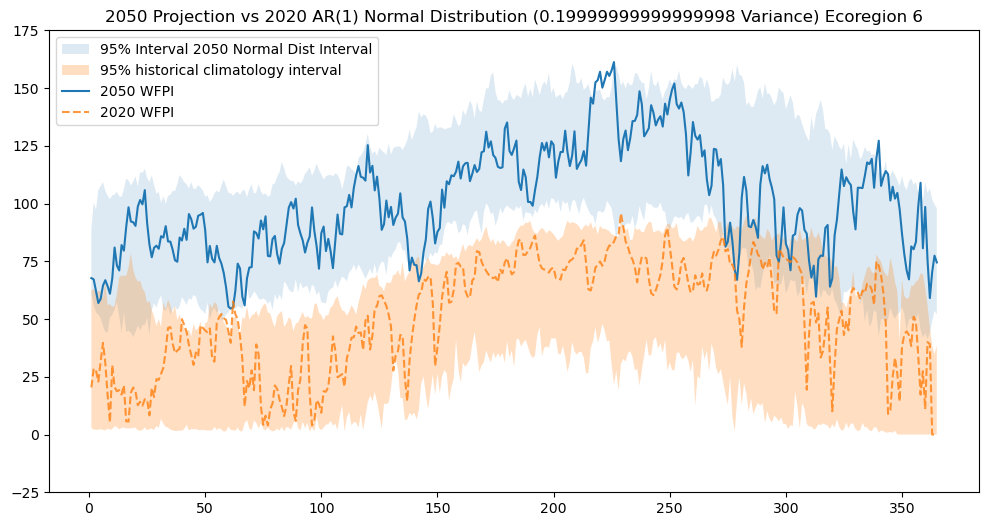

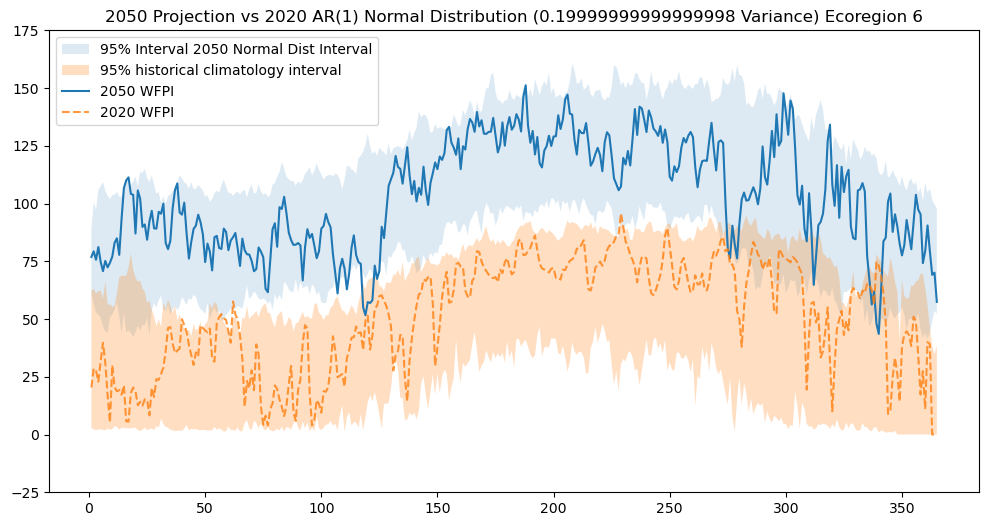

In [15]:
speedy_iteration_combination = np.arange(0,len(col_names))
for easy_counting_for_func in speedy_iteration_combination:
    representative_historical_year = 2020
    time_series_vals = []
    iteration, iteration_counter = col_names[easy_counting_for_func], easy_counting_for_func
    shapefile_indv = group_n[iteration_counter]
    functionationer(shapefile_indv)
    
    # deals with the year/day xarray dataset coords by extracting them to a new var
    # this can be avoided if the data originates in datetime[64] or is in a pandas df, 
    # however this data starts spatially and is loaded in in netcdf format not in datetime.
    values = []
    for year in np.arange(2001, 2023):
        for day in np.arange(1,366):
            year_day = time_series_vals[0].sel(year=year, day=day)
            values.append(year_day.values.item())
    
    # this simply plots the time series at a given locationxarray_array
    fig, ax = plt.subplots(figsize=(10, 6))
    
    plt.plot(values)
    plt.title('WFPI Time Series Ecoregion '+ str(iteration), fontsize=13)
    plt.xlabel('time (in days 2001 - 2022)')
    plt.ylabel('WFPI')
    plt.savefig('ecoregions/' + str(iteration) + '/0_region_' + str(iteration) + '_dailytimeseries')
    
    xarray_array = time_series_vals[0]
    
    # now we use the 'year' var of xarray for daily climatology (ignoring leap year)
    daily_climatology = xarray_array.mean(dim='year')
    
    # the below code gives us the 95% interval
    top_bounds = []
    btm_bounds = []
    for day in np.arange(1,366):
        single_day_vals = xarray_array.sel(day=day)
        _95_percent = np.nanpercentile(single_day_vals.values, 97.5)
        _25_percent = np.nanpercentile(single_day_vals.values, 2.5)
        top_bounds.append(_95_percent)
        btm_bounds.append(_25_percent)
    
    # it is now important to get a smoothed climatology, which is done by simply repeating the daily 
    # climatology 3 times and then centering the rolling smoother:
    
    repeated_climatology = []
    for i in np.arange(1,4):
        for value in daily_climatology.values:
            repeated_climatology.append(value)
    
    # 
    df_for_smoothing = pd.DataFrame(repeated_climatology, columns=['wfpi'])
    df_smoothed_climatology = df_for_smoothing.rolling(window=30, center=True).mean()
    selected_values_smooth = df_smoothed_climatology[(df_smoothed_climatology.index >= 365)
                                                & (df_smoothed_climatology.index <= 729)]
    
    selected_values_smooth['day'] = np.arange(1, 366)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.fill_between(np.arange(1,366), btm_bounds, top_bounds, alpha=.25, label='95% climatology interval')
    daily_climatology.plot(label='daily WFPI')
    plt.plot(np.arange(1,366), selected_values_smooth.wfpi, label='smoothed 30day')
    plt.title('Daily Climatology ' + 'Ecoregion ' + str(iteration), fontsize=13)
    plt.ylabel('WFPI')
    plt.legend()
    plt.savefig('ecoregions/' + str(iteration) + '/1_region_' + str(iteration) + 'daily_climatology')
    
    # this now does some aggregation in order to visualize the dates for sanity check
    
    start_day = 152
    end_day = 304
    
    ds_filtered_summer = xarray_array.where(xarray_array['day'] >= start_day, drop=True)
    ds_filtered_summer = ds_filtered_summer.where(ds_filtered_summer['day'] <= end_day, drop=True)
    yearly_mean = ds_filtered_summer.mean(dim='day')
    
    #this gives us a usable input into polyval
    all_time = np.arange(2001, 2051)
    coord_da = xr.DataArray(all_time, dims='time', coords={'time': all_time})
    
    poly_coeffs = yearly_mean.polyfit(dim=('year'), deg=1).rename({"polyfit_coefficients":"fwpi"}) 
    poly_fits = xr.polyval(coord=coord_da, coeffs=poly_coeffs)
    trendline = poly_coeffs.sel(degree=1)
    
    trendline_values = xr.polyval(coord=yearly_mean['year'], coeffs=poly_coeffs)
    # this gives me my mx+b value at each point, essentially giving me the predicted value from the linear regression
    residuals = yearly_mean.values - trendline_values
    standard_deviation_residuals = residuals.std(dim='year')
    standard_deviation = yearly_mean.std(dim='year')
    # the next line of code makes all the exaclty 0 slopes into nan to avoid plotting nonsense 
    
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.scatter(np.arange(2001, 2023), yearly_mean.values, label='WFPI JJASO Avg')
    yearly_mean.plot(alpha=.4)
    plt.plot(np.arange(2001, 2051), poly_fits.fwpi, label='Projected WFPI', c='black')
    plt.title('JJASO WFPI Summer Trend Historical Ecoregion ' + str(iteration))
    plt.ylabel('WFPI')
    plt.legend()
    plt.savefig('ecoregions/' + str(iteration) + '/2_region_' + str(iteration) + '_JJASO_avergaeprojected_future_trend.png')
    #print('2050 WFPI Summer Projection is ' + str(poly_fits.fwpi[-1].values))
    
    start_day = 152 
    end_day = 304
    
    ds_filtered_summer_DC = selected_values_smooth.where(selected_values_smooth['day'] >= start_day)
    ds_filtered_summer_DC = ds_filtered_summer_DC.where(ds_filtered_summer_DC['day'] <= end_day)
    yearly_mean_DC = ds_filtered_summer_DC.mean()
    
    # in this case the yearly_mean_DC is average for the JJASO period over the daily climatology
    # it happens to 81.28223411, and the 2050 proj happens to be 86.14623477873806
    # the difference between these two is 4.86400067
    #########    print((poly_fits.fwpi[-1].values) - yearly_mean_DC)
    
    # we now know to shift the daily climatology vertically by 29.186378 units 
    
    shifted_daily_climatology = selected_values_smooth['wfpi'] + ((poly_fits.fwpi[-1].values) - yearly_mean_DC)[0]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    plt.plot(np.arange(1,366), shifted_daily_climatology, label='shifted daily climatology smoothed')
    plt.plot(np.arange(1,366), selected_values_smooth.wfpi, label='daily climatology smoothed')
    plt.title('Shifted Daily Climatology (' + str(((poly_fits.fwpi[-1].values) - yearly_mean_DC).wfpi) + ') Ecoregion ' + str(iteration))
    plt.ylabel('WFPI')
    plt.legend()
    plt.savefig('ecoregions/' + str(iteration) + '/4_region_' + str(iteration) + '_shifted_daily_climatology.png')
    print(print((poly_fits.fwpi[-1].values) - yearly_mean_DC))
    
    # we now need to 
    #get residuals, i.e. subtract the daily_climatology from xarray_array
    # residuals are the smoothed daily climatology minus the wfpi all time data
    
    smoothed_8030_values = []
    for year in np.arange(2001, 2023):
        for value_smooth in selected_values_smooth.wfpi:
            smoothed_8030_values.append(value_smooth)
    
    # RESIDUALS DEFINED HERE
    residuals_smoothed_minus_real = np.array(values) - np.array(smoothed_8030_values)   
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    plt.plot(residuals_smoothed_minus_real, label='residual')
    
    plt.title('Residuals, Smoothed Daily Clim Minus Daily WFPI Ecoregion ' + str(iteration))
    plt.ylabel('WFPI')
    plt.xlabel('days')
    plt.legend()
    plt.savefig('ecoregions/' + str(iteration) + '/5_region_' + str(iteration) + 'residuals_smoothed_climatology_minus_daily_Wfpi.png')
    
    # then we need to block the resiuduals by month and by year
    
    # first we make a pandas dataframe, for both year and the residuals so we can groupby later with datetime
    # not great programming, but makes a few extra dataframes, then gets rid of leaps, resets index 
    # and combines dataframes then sets the index to be datetime
    
    residuals_time_df = pd.DataFrame({'residuals_smoothed_minus_real': residuals_smoothed_minus_real})
    datetime_range_wleap = pd.date_range(start='01-01-2001', end='12-31-2022', freq="d")
    time_df_leap = pd.DataFrame({'time_wleap': datetime_range_wleap})
    
    datetime_range_noleap = time_df_leap[~((time_df_leap['time_wleap'].dt.month == 2) & (time_df_leap['time_wleap'].dt.day == 29))]
    datetime_range_noleap = datetime_range_noleap.dropna()
    datetime_range_noleap = datetime_range_noleap.reset_index(drop=True)
    residuals_time_df['date'] = datetime_range_noleap['time_wleap']
    residuals_time_df = residuals_time_df.set_index("date")
    # due to some null values in the underlying data we drop them. Alternatively we could set them to zero, which we also show
    
    residuals_time_df_nonnull = residuals_time_df.dropna(subset=['residuals_smoothed_minus_real'])
    residuals_time_df_nulltozero = residuals_time_df['residuals_smoothed_minus_real'].fillna(0)
    
    # residuals_time_df now has residuals in dataframe so we can group by month, day, for easier discretized bootstrap
    
    # PACF function to make sure AR1 model is appropriate, and to check the multiplitive ar1 factor
    
    autocorrelation_dropnan = sm.tsa.pacf(residuals_time_df_nonnull['residuals_smoothed_minus_real'], nlags=50)
    autocorrelation_zeronan = sm.tsa.pacf(residuals_time_df_nulltozero, nlags=50)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(autocorrelation_dropnan)), autocorrelation_dropnan, label='Nan Dropped Smoothed Daily Climatology Resids PACF', s=30)
    plt.plot(range(len(autocorrelation_dropnan)), autocorrelation_dropnan, alpha=.3)
    
    plt.scatter(range(len(autocorrelation_zeronan)), autocorrelation_zeronan, label='Nan to Zero Smoothed Daily Climatology Resids PACF', s=30)
    plt.plot(range(len(autocorrelation_zeronan)), autocorrelation_zeronan, alpha=.3)
    
    plt.title('PACF 30 Day Smoothed (35.525, -118.974999) Ecoregion ' + str(iteration), fontsize=16)
    plt.xlabel('number of lags')
    plt.ylabel('partial autocorrelation')
    
    plt.legend()
    plt.savefig('ecoregions/' + str(iteration) + '/3_region_' + str(iteration) + '_PACF_30day_smoothed')
    print('zeroed nan pacf at 1 lag is ' + str(autocorrelation_zeronan[1]))
    print('dropped nan pacf at 1 lag is ' + str(autocorrelation_dropnan[1]))
    
    # Same PACF as Monthly Block Approach
    PACF_const = autocorrelation_dropnan[1]
    
    # grouping by day and month, where to get group we use a tuple of (day, month)
    df_grouped = residuals_time_df_nonnull.groupby([residuals_time_df_nonnull.index.month, residuals_time_df_nonnull.index.day])
    
    days_in_each_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    list_of_normdist_arrays = []
    # how many bootstraps do we want ?
    
    number_of_2050_iterations = 100
    std_dev_divisor = (4**(1/2))
    
    for iteration_bs in np.arange(0, number_of_2050_iterations):
        residual_time_series_norm = []
        
        # using the grouped dfs from previous cell, resampling using .sample().iloc and appending to the array of 'new' resids
        january_group = df_grouped.get_group((1, 1))
        residual_singleday_for_timeseries = january_group['residuals_smoothed_minus_real']
        std_dev_ts = np.std(residual_singleday_for_timeseries) * (1/(std_dev_divisor))
        mean_ts = np.mean(residual_singleday_for_timeseries)
        random_values_mean_zero = np.random.normal(loc=0, scale=std_dev_ts, size=500)
        
        first_residual = np.random.choice(random_values_mean_zero)
        residual_time_series_norm.append(first_residual)
        
        for month_integer in np.arange(1,13):
            # using the grouped dfs from previous cell, resampling using .sample().iloc and appending to the array of 'new' resids        
            for day_integer in np.arange(1, days_in_each_month[month_integer-1] + 1):
                if day_integer == 1 and month_integer == 1:
                    #print(iteration_bs)
                    continue
                else:
                    month_day_being_pulled_from = df_grouped.get_group((month_integer, day_integer))
                    residual_singleday_for_timeseries = month_day_being_pulled_from['residuals_smoothed_minus_real']
                    
                    std_dev_ts = np.std(residual_singleday_for_timeseries) * (1/(std_dev_divisor))
                    mean_ts = np.mean(residual_singleday_for_timeseries)
                    
                    random_values_mean_zero = np.random.normal(loc=0, scale=std_dev_ts, size=500)
                    
                    new_residual_not_first = np.random.choice(random_values_mean_zero)
                    new_resid_withpacf_not_first = residual_time_series_norm[-1] * PACF_const + new_residual_not_first
                    residual_time_series_norm.append(new_resid_withpacf_not_first)
            
        list_of_normdist_arrays.append(residual_time_series_norm)
    
    artificial_climatologies = []
    for norm_resids in list_of_normdist_arrays:
        artificial_timeseries = shifted_daily_climatology + norm_resids
        # now fit a centered smoothed, cyclical moving average
        repeated_climatology_bs = []
        for i in np.arange(1,4):
            for value in artificial_timeseries.values:
                repeated_climatology_bs.append(value)
        
        # 
        df_for_smoothing_bs = pd.DataFrame(repeated_climatology_bs, columns=['wfpi'])
        df_smoothed_climatology_bs = df_for_smoothing_bs.rolling(window=30, center=True).mean()
        selected_values_smooth_ds = df_smoothed_climatology_bs[(df_smoothed_climatology_bs.index >= 365)
                                                    & (df_smoothed_climatology_bs.index <= 729)]
        artificial_climatologies.append(selected_values_smooth_ds)
    
    # Finally we must take the confidence interval for the Bootstrapped Iterations
    values_for_ci =[]
    for example_year in list_of_normdist_arrays:
        residuals_plus_shifted_climatology_unsmoothed = shifted_daily_climatology + example_year
        values_for_ci.append(residuals_plus_shifted_climatology_unsmoothed)
        
        
    _975_percentile_topbounds = np.nanpercentile(values_for_ci, 97.5, axis=0).tolist()
    _025_percentile_btm_bounds = np.nanpercentile(values_for_ci, 2.5, axis=0).tolist()
    _975_percentile_topbounds = np.reshape(_975_percentile_topbounds, ((365,)))
    _025_percentile_btmbounds = np.reshape(_025_percentile_btm_bounds, ((365,)))
    
    plt.figure(figsize=(12, 6))
    for ind_2050_proj in artificial_climatologies[1:]:
        plt.plot(np.arange(1,366), ind_2050_proj, alpha=.1, c='grey')
    
    plt.plot(np.arange(1,366), artificial_climatologies[0], alpha=.1, c='grey', label='Norm Dist 2050 Smoothed')
    
    plt.fill_between(np.arange(1,366), _975_percentile_topbounds, _025_percentile_btmbounds, alpha=.25, label='95% 2050 Norm Dist Interval (unsmoothed)')
    plt.plot(np.arange(1,366), shifted_daily_climatology, label='Shifted 2050 Smoothed Climatology')
    plt.plot(np.arange(1,366), selected_values_smooth['wfpi'], label='Historical Smoothed Climatology')
    plt.legend()
    plt.title('WFPI DAILY Norm Dist AR(1) 2050 Projections ' + str(number_of_2050_iterations) + ' Iterations Ecoregion ' +str(iteration), fontsize=14)
    plt.xlabel('days')
    plt.ylabel('WFPI')
    plt.ylim(-25, 175)  
    
    #plt.savefig('ecoregions/' + str(iteration) + '/6_region_' + str(iteration) +_daily'
    
    representative_historical_year_plot = xarray_array.sel(year=representative_historical_year)
    iterations_to_plot = 3
    for i in np.arange(0, iterations_to_plot):
        artificial_timeseries_toplot = list_of_normdist_arrays[i] + shifted_daily_climatology
        plt.figure(figsize=(12, 6))
        
        plt.title(f'2050 Projection vs {representative_historical_year} AR(1) Normal Distribution ({(1/std_dev_divisor)**2} Variance) Ecoregion {iteration}')
        plt.fill_between(np.arange(1,366), _975_percentile_topbounds, _025_percentile_btmbounds, alpha=.15, label='95% Interval 2050 Normal Dist Interval')
        plt.fill_between(np.arange(1,366), btm_bounds, top_bounds, alpha=.25, label='95% historical climatology interval')
    
        plt.plot(np.arange(1,366), artificial_timeseries_toplot, label='2050 WFPI')
        plt.plot(np.arange(1,366), representative_historical_year_plot.values, label=f'{representative_historical_year} WFPI', alpha=.8, linestyle='--')
        plt.legend()
        plt.ylim(-25, 175)  
        plt.savefig(f'ecoregions/{iteration}/7_region_{iteration}_projected_2050_onefourth_variance_{i}_{representative_historical_year}.png')
    
        #############################################################################################################################
    # Same PACF as Monthly Block Approach
    PACF_const = autocorrelation_dropnan[1]
    
    # grouping by day and month, where to get group we use a tuple of (day, month)
    df_grouped = residuals_time_df_nonnull.groupby([residuals_time_df_nonnull.index.month, residuals_time_df_nonnull.index.day])
    
    days_in_each_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    list_of_normdist_arrays = []
    # how many bootstraps do we want ?
    
    number_of_2050_iterations = 100
    std_dev_divisor = (5**(1/2))
    
    for iteration_bs in np.arange(0, number_of_2050_iterations):
        residual_time_series_norm = []
        
        # using the grouped dfs from previous cell, resampling using .sample().iloc and appending to the array of 'new' resids
        january_group = df_grouped.get_group((1, 1))
        residual_singleday_for_timeseries = january_group['residuals_smoothed_minus_real']
        std_dev_ts = np.std(residual_singleday_for_timeseries) * (1/(std_dev_divisor))
        mean_ts = np.mean(residual_singleday_for_timeseries)
        random_values_mean_zero = np.random.normal(loc=0, scale=std_dev_ts, size=500)
        
        first_residual = np.random.choice(random_values_mean_zero)
        residual_time_series_norm.append(first_residual)
        
        for month_integer in np.arange(1,13):
            # using the grouped dfs from previous cell, resampling using .sample().iloc and appending to the array of 'new' resids        
            for day_integer in np.arange(1, days_in_each_month[month_integer-1] + 1):
                if day_integer == 1 and month_integer == 1:
                    #print(iteration_bs)
                    continue
                else:
                    month_day_being_pulled_from = df_grouped.get_group((month_integer, day_integer))
                    residual_singleday_for_timeseries = month_day_being_pulled_from['residuals_smoothed_minus_real']
                    
                    std_dev_ts = np.std(residual_singleday_for_timeseries) * (1/(std_dev_divisor))
                    mean_ts = np.mean(residual_singleday_for_timeseries)
                    
                    random_values_mean_zero = np.random.normal(loc=0, scale=std_dev_ts, size=500)
                    
                    new_residual_not_first = np.random.choice(random_values_mean_zero)
                    new_resid_withpacf_not_first = residual_time_series_norm[-1] * PACF_const + new_residual_not_first
                    residual_time_series_norm.append(new_resid_withpacf_not_first)
            
        list_of_normdist_arrays.append(residual_time_series_norm)
    
    artificial_climatologies = []
    for norm_resids in list_of_normdist_arrays:
        artificial_timeseries = shifted_daily_climatology + norm_resids
        # now fit a centered smoothed, cyclical moving average
        repeated_climatology_bs = []
        for i in np.arange(1,4):
            for value in artificial_timeseries.values:
                repeated_climatology_bs.append(value)
        
        # 
        df_for_smoothing_bs = pd.DataFrame(repeated_climatology_bs, columns=['wfpi'])
        df_smoothed_climatology_bs = df_for_smoothing_bs.rolling(window=30, center=True).mean()
        selected_values_smooth_ds = df_smoothed_climatology_bs[(df_smoothed_climatology_bs.index >= 365)
                                                    & (df_smoothed_climatology_bs.index <= 729)]
        artificial_climatologies.append(selected_values_smooth_ds)
    
    # Finally we must take the confidence interval for the Bootstrapped Iterations
    values_for_ci =[]
    for example_year in list_of_normdist_arrays:
        residuals_plus_shifted_climatology_unsmoothed = shifted_daily_climatology + example_year
        values_for_ci.append(residuals_plus_shifted_climatology_unsmoothed)
        
        
    _975_percentile_topbounds = np.nanpercentile(values_for_ci, 97.5, axis=0).tolist()
    _025_percentile_btm_bounds = np.nanpercentile(values_for_ci, 2.5, axis=0).tolist()
    _975_percentile_topbounds = np.reshape(_975_percentile_topbounds, ((365,)))
    _025_percentile_btmbounds = np.reshape(_025_percentile_btm_bounds, ((365,)))
    
    plt.figure(figsize=(12, 6))
    for ind_2050_proj in artificial_climatologies[1:]:
        plt.plot(np.arange(1,366), ind_2050_proj, alpha=.1, c='grey')
    
    plt.plot(np.arange(1,366), artificial_climatologies[0], alpha=.1, c='grey', label='Norm Dist 2050 Smoothed')
    
    plt.fill_between(np.arange(1,366), _975_percentile_topbounds, _025_percentile_btmbounds, alpha=.25, label='95% 2050 Norm Dist Interval (unsmoothed)')
    plt.plot(np.arange(1,366), shifted_daily_climatology, label='Shifted 2050 Smoothed Climatology')
    plt.plot(np.arange(1,366), selected_values_smooth['wfpi'], label='Historical Smoothed Climatology')
    plt.legend()
    plt.title('WFPI DAILY Norm Dist AR(1) 2050 Projections ' + str(number_of_2050_iterations) + ' Iterations Ecoregion ' +str(iteration), fontsize=14)
    plt.xlabel('days')
    plt.ylabel('WFPI')
    plt.ylim(-25, 175)  
    
    #plt.savefig('ecoregions/' + str(iteration) + '/6_region_' + str(iteration) +_daily'
    representative_historical_year_plot = xarray_array.sel(year=representative_historical_year)
    iterations_to_plot = 3
    for i in np.arange(0, iterations_to_plot):
        artificial_timeseries_toplot = list_of_normdist_arrays[i] + shifted_daily_climatology
        plt.figure(figsize=(12, 6))
        
        plt.title(f'2050 Projection vs {representative_historical_year} AR(1) Normal Distribution ({(1/std_dev_divisor)**2} Variance) Ecoregion {iteration}')
        plt.fill_between(np.arange(1,366), _975_percentile_topbounds, _025_percentile_btmbounds, alpha=.15, label='95% Interval 2050 Normal Dist Interval')
        plt.fill_between(np.arange(1,366), btm_bounds, top_bounds, alpha=.25, label='95% historical climatology interval')
    
        plt.plot(np.arange(1,366), artificial_timeseries_toplot, label='2050 WFPI')
        plt.plot(np.arange(1,366), representative_historical_year_plot.values, label=f'{representative_historical_year} WFPI', alpha=.8, linestyle='--')
        plt.legend()
        plt.ylim(-25, 175)  
        plt.savefig(f'ecoregions/{iteration}/7_region_{iteration}_projected_2050_onefifth_variance_{i}_{representative_historical_year}.png')
        

/tmp/ipykernel_107504/362963302.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


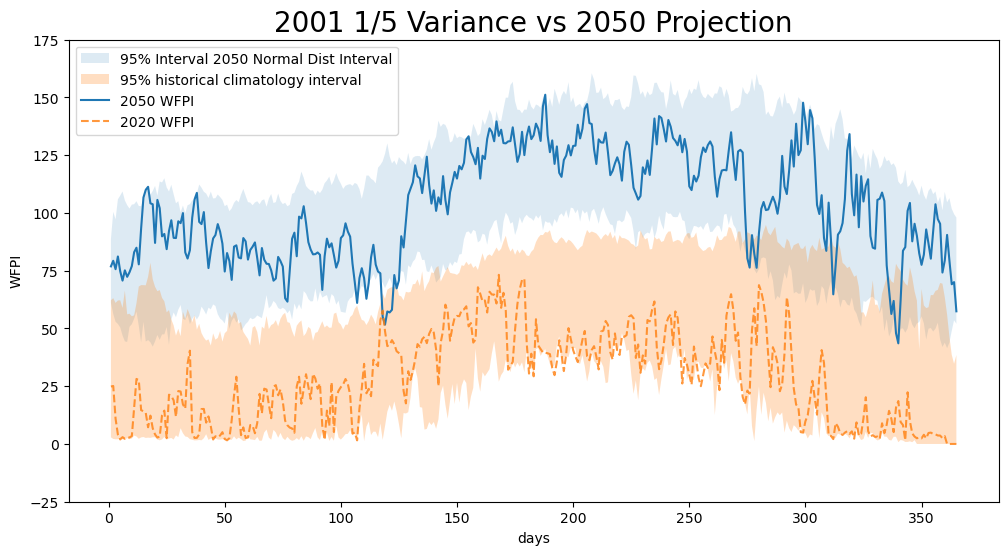

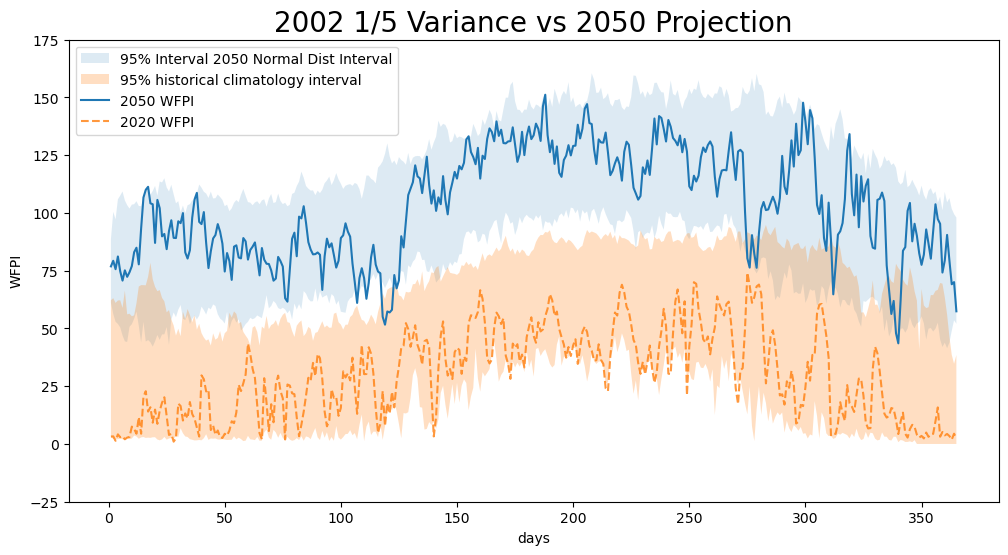

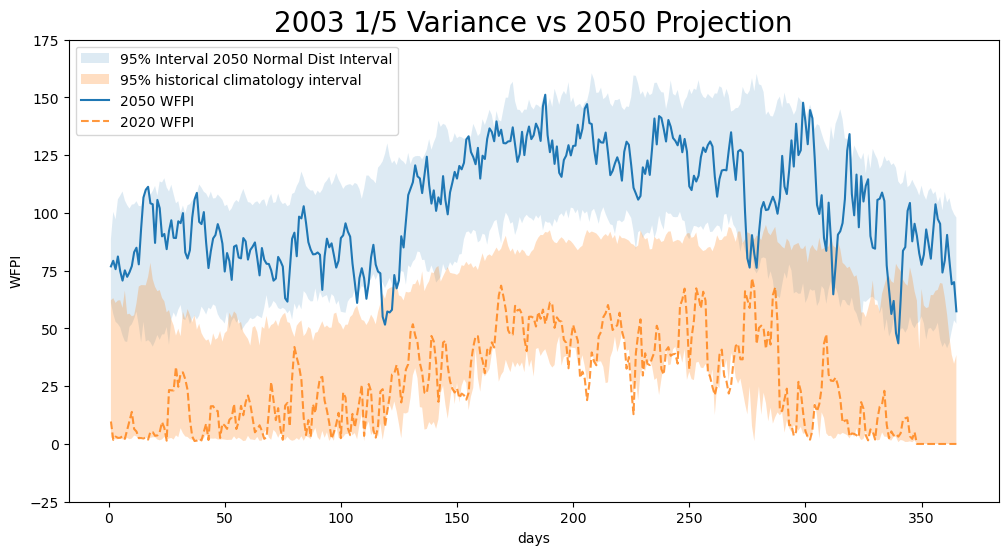

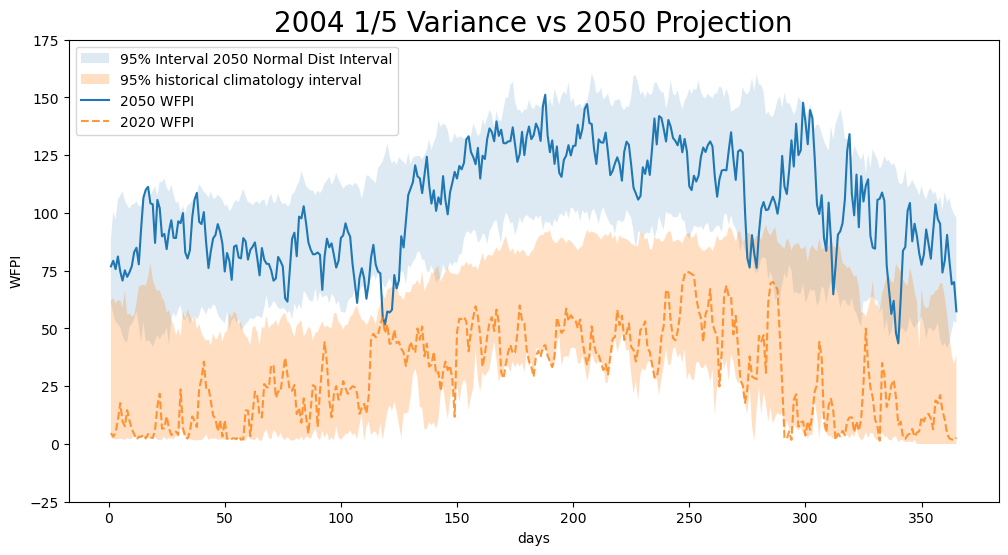

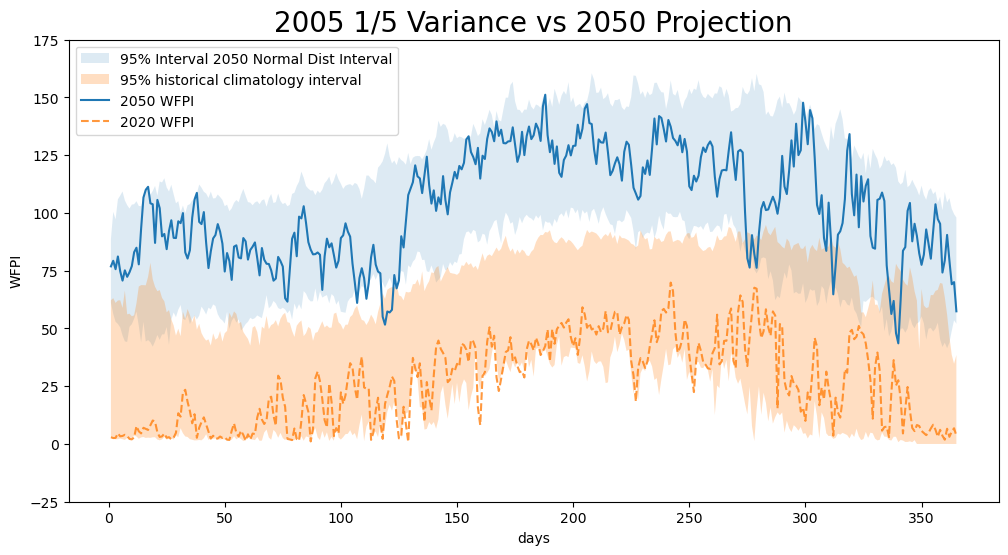

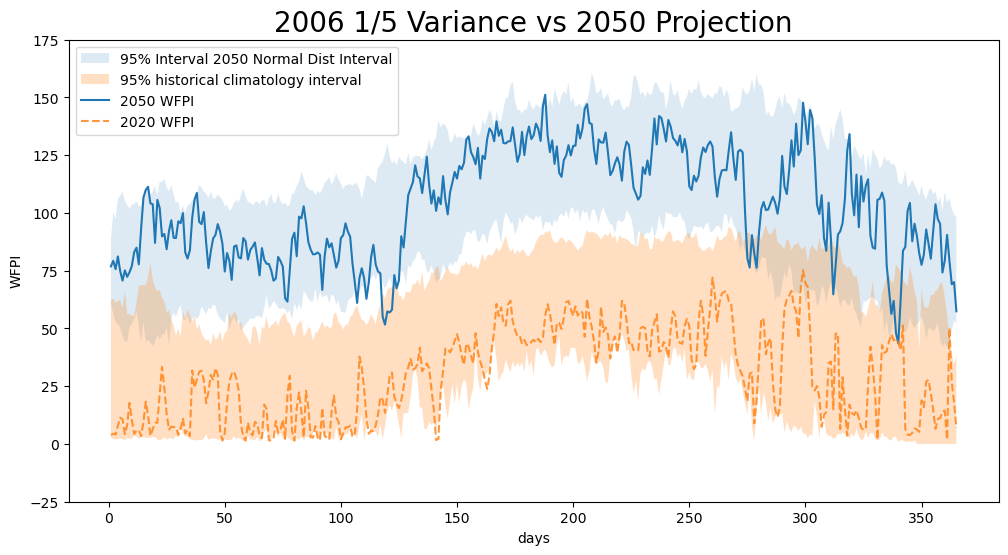

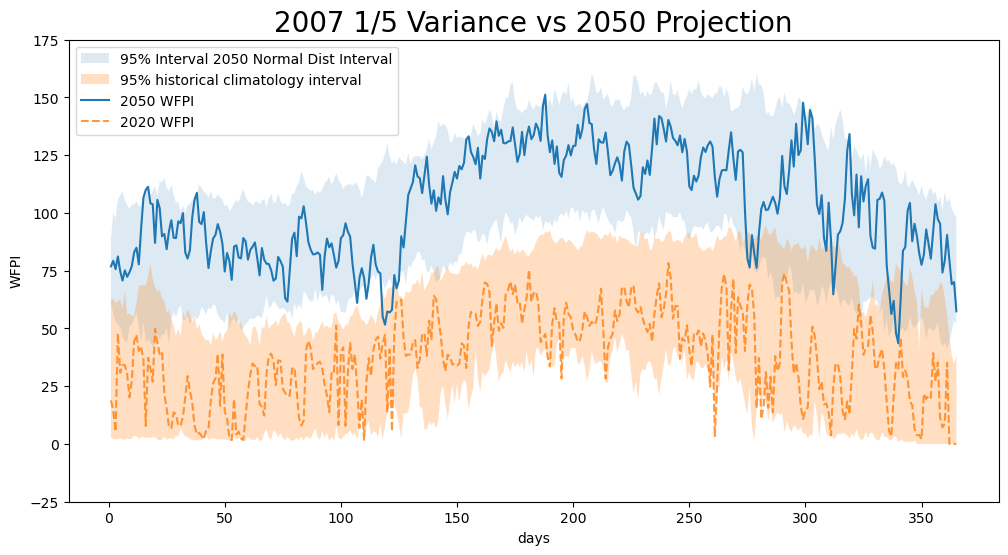

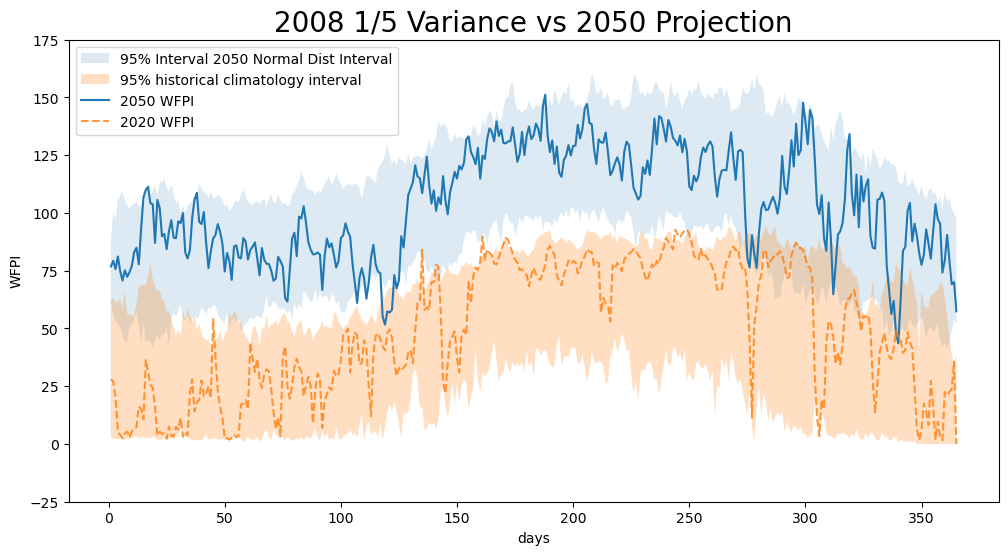

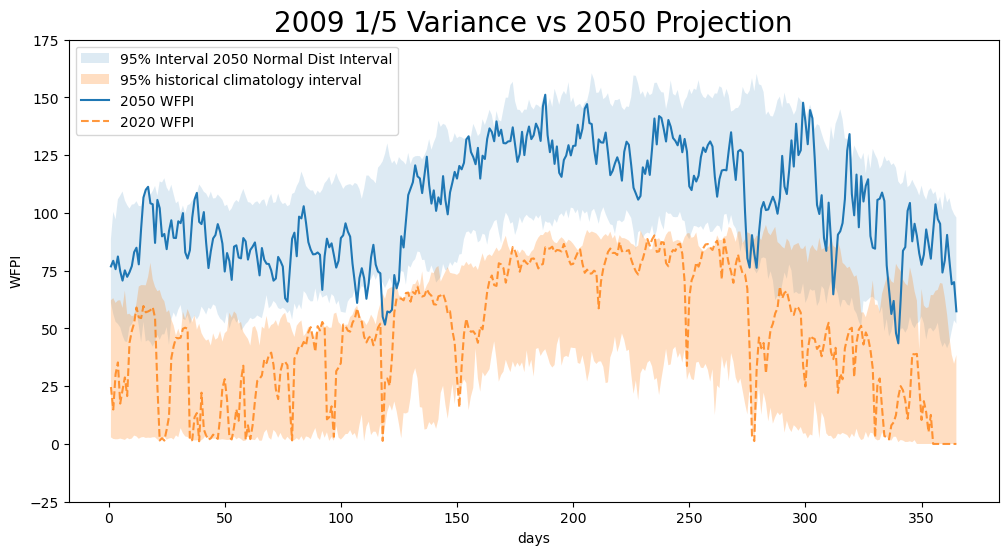

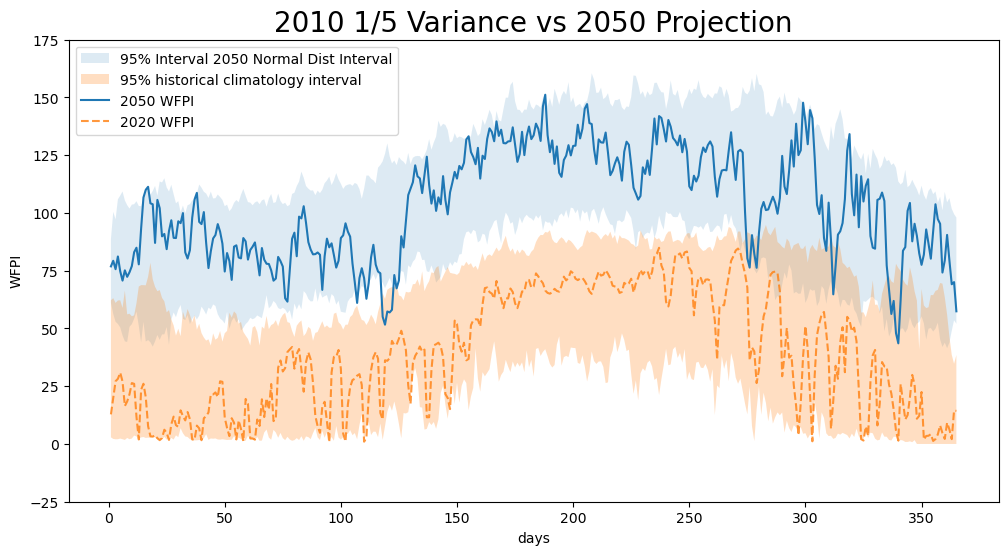

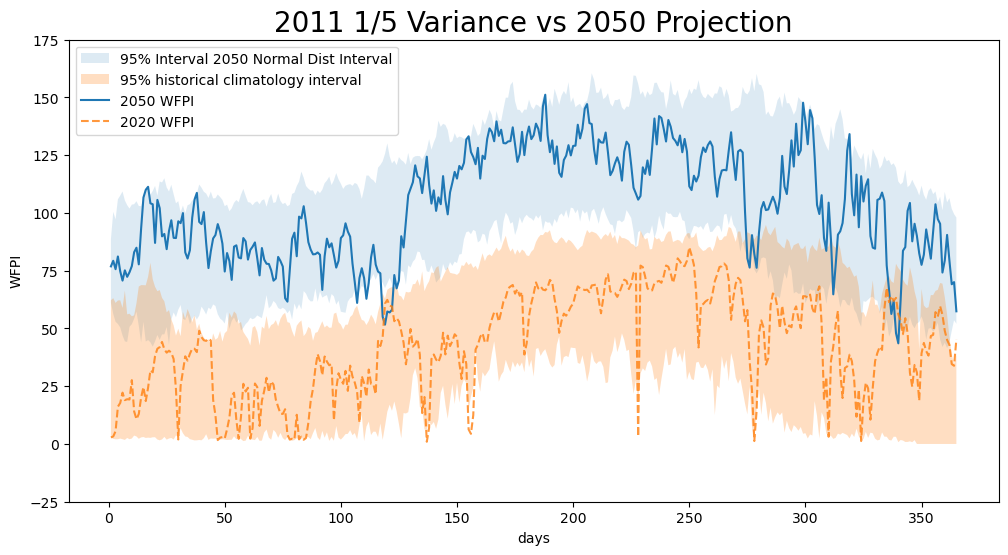

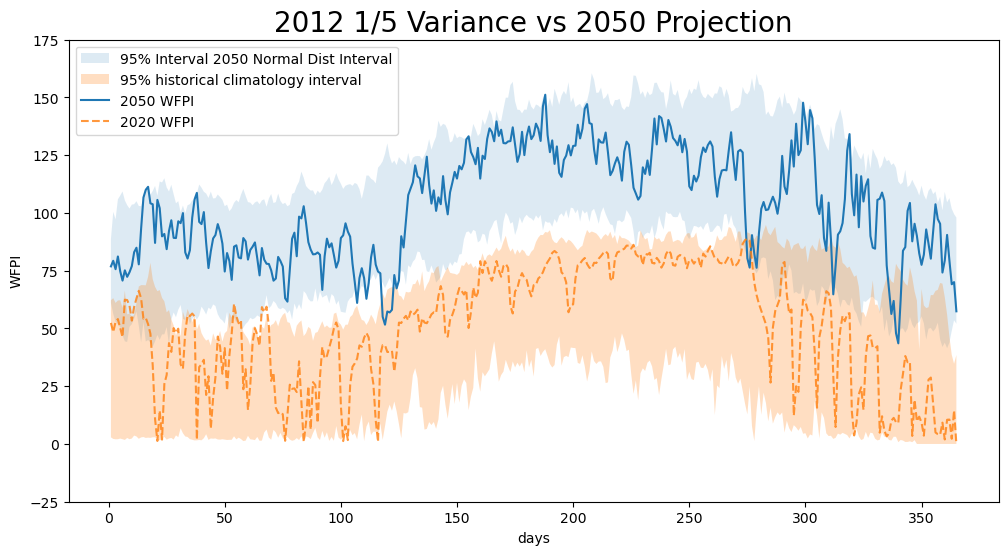

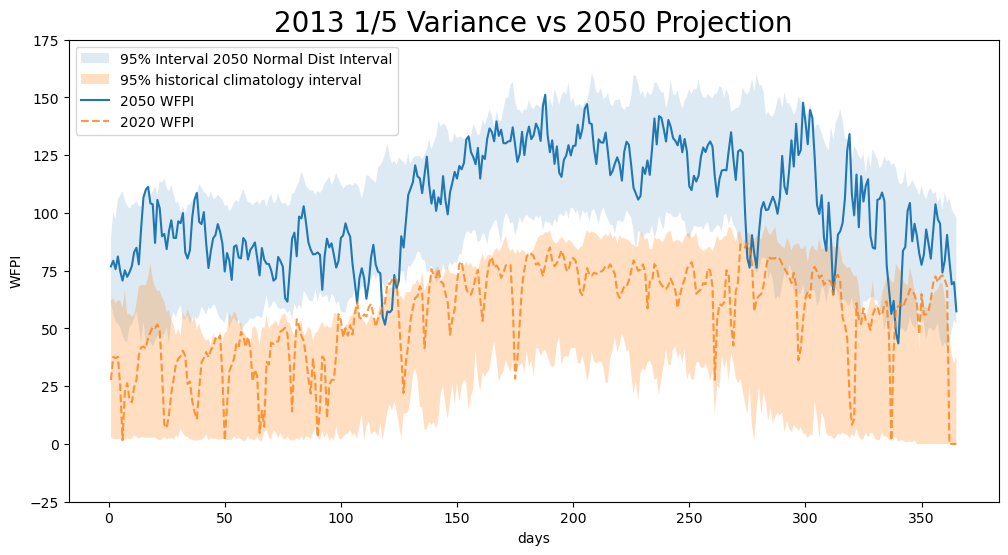

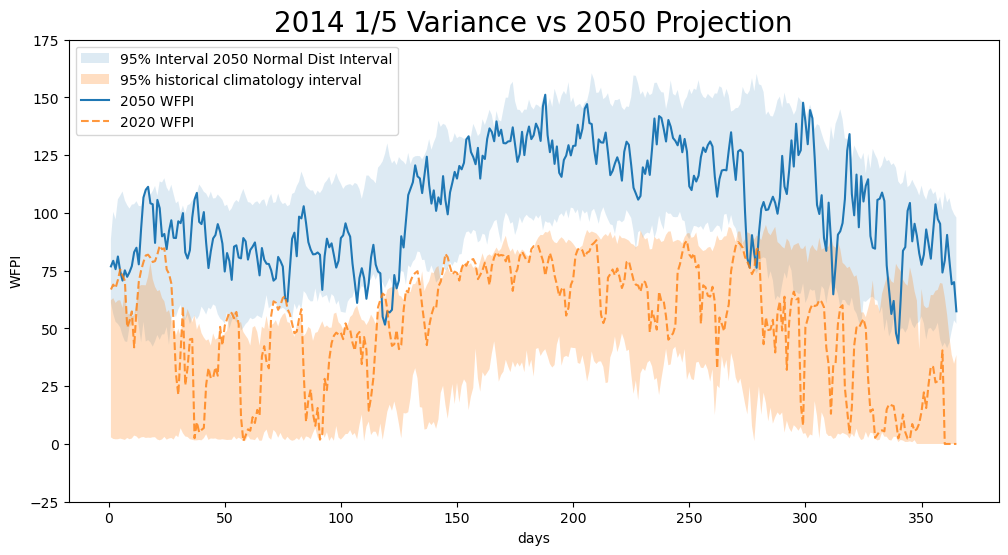

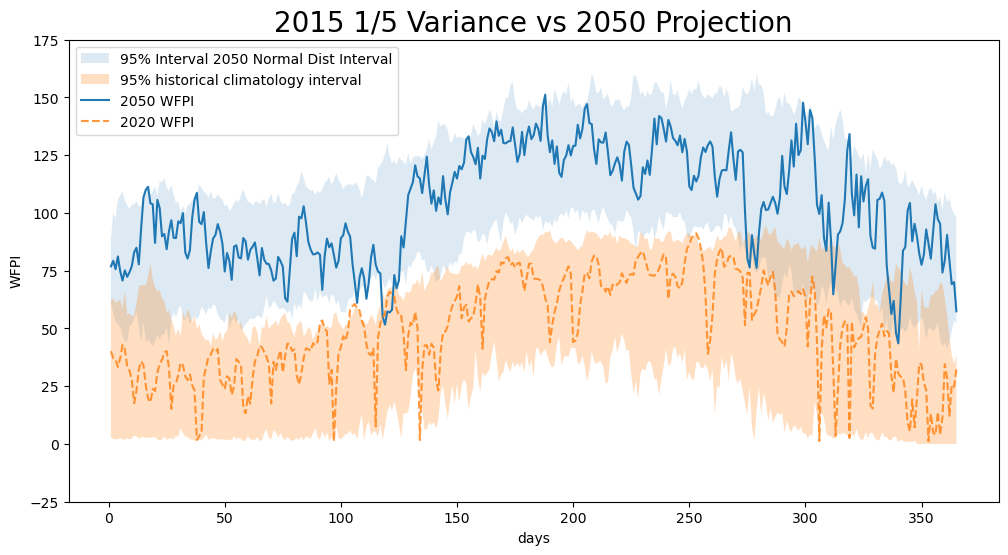

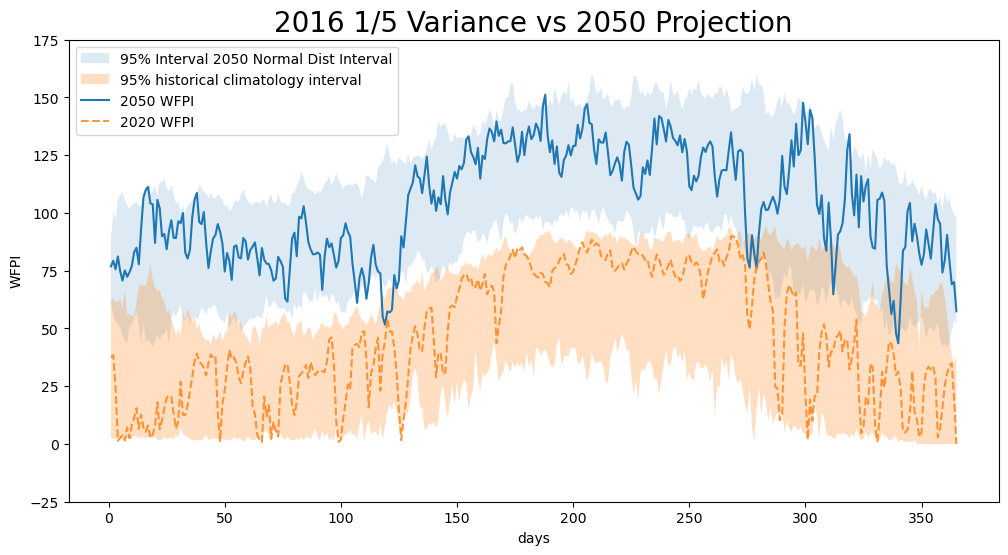

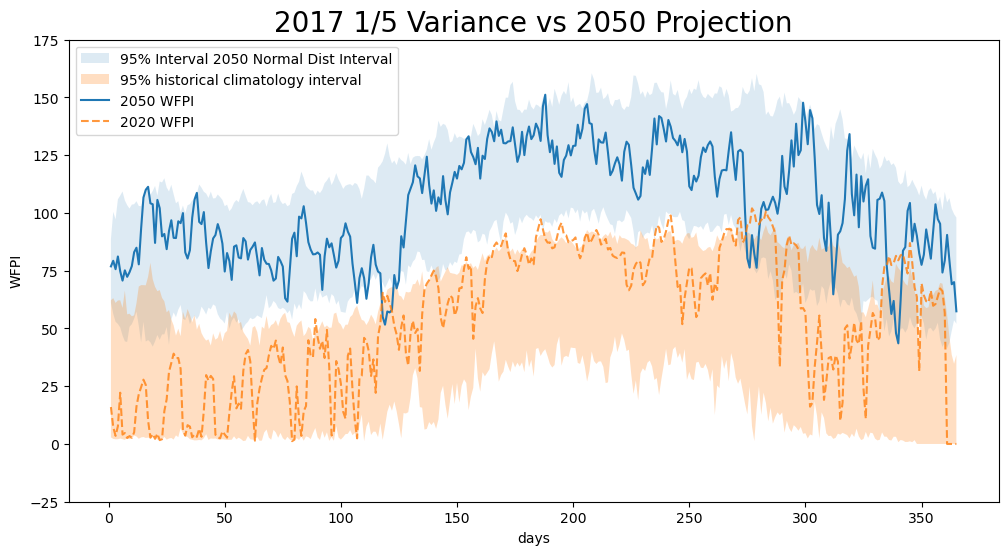

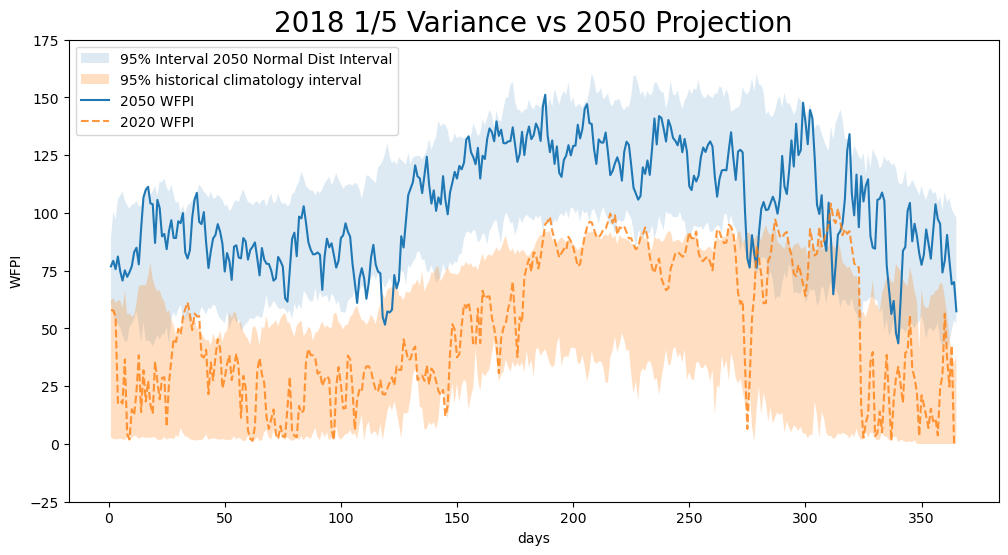

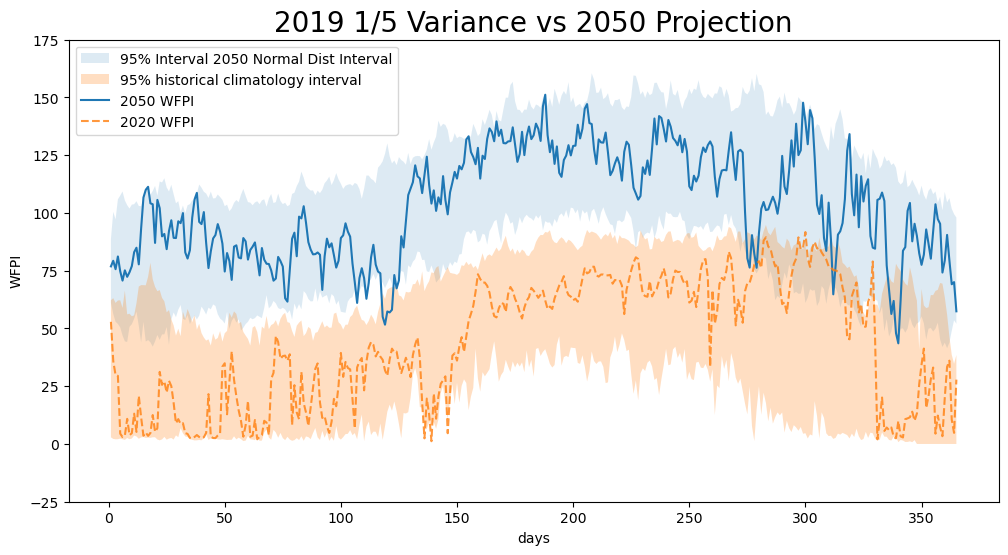

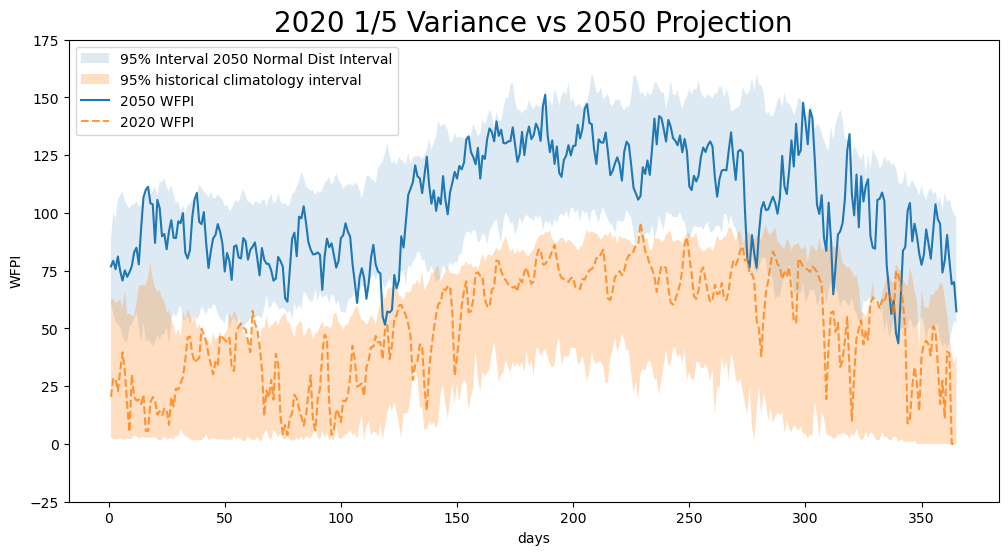

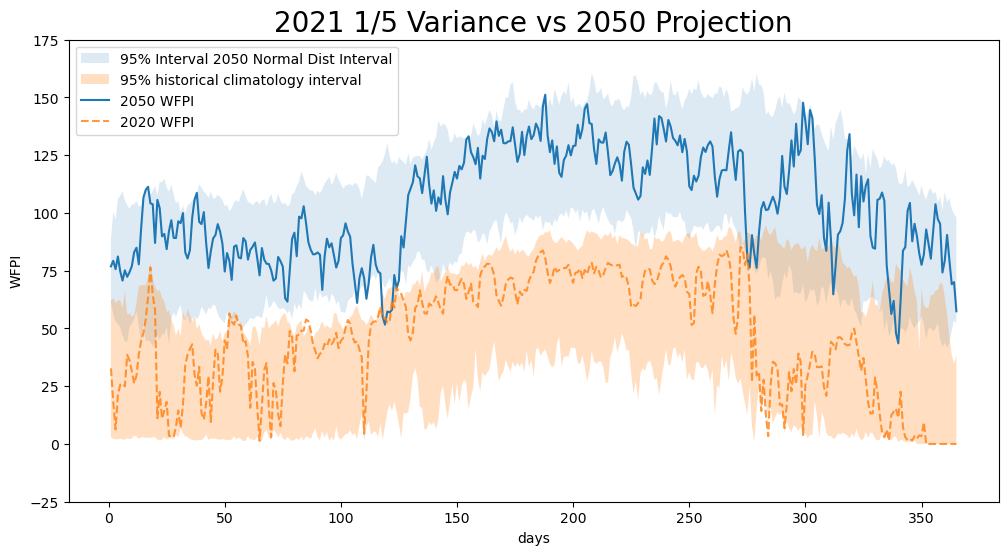

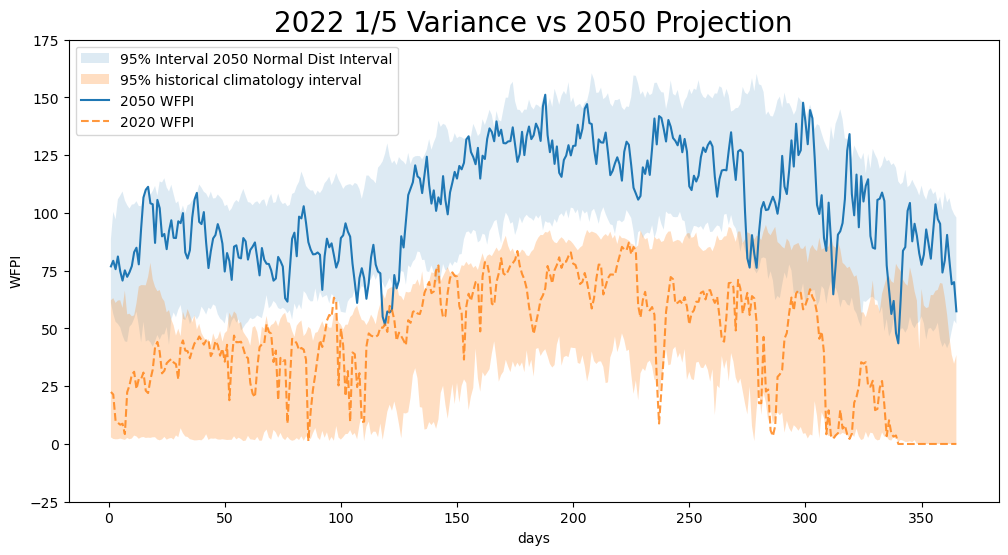

In [17]:
for year in xarray_array.year.values:
    year_iteration_i = xarray_array.sel(year=year)
    plt.figure(figsize=(12, 6))
    plt.title(f'{year} 1/5 Variance vs 2050 Projection', fontsize = 20)

    plt.fill_between(np.arange(1,366), _975_percentile_topbounds, _025_percentile_btmbounds, alpha=.15, label='95% Interval 2050 Normal Dist Interval')
    plt.fill_between(np.arange(1,366), btm_bounds, top_bounds, alpha=.25, label='95% historical climatology interval')

    plt.plot(np.arange(1,366), artificial_timeseries_toplot, label='2050 WFPI')
    plt.plot(np.arange(1,366), year_iteration_i.values, label=f'{representative_historical_year} WFPI', alpha=.8, linestyle='--')
    plt.legend()
    plt.ylim(-25, 175)  
    plt.xlabel('days')
    plt.ylabel('WFPI')
    plt.savefig(f'june23_allyears/{year}historical_years.png')